<a href="https://colab.research.google.com/github/AryanJadhao/Vision-Transformer/blob/main/Vision_Transformer_(CIFAR10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [69]:
import torch
import torchvision
from torch.utils.data import dataloader

In [70]:
# transformation --> data Augmentation
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.4914, 0.4822, 0.4465],
        std=[0.2023, 0.1994, 0.2010]
    )
])



In [71]:
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

In [72]:
num_features = 10
img_size = 32
patch_size = 8
num_patches = (img_size // patch_size)**2
batch_size = 64
num_channels = 3
embedding_dim = 192
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 768
num_epochs = 20
learning_rate = 3e-4


In [73]:
train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = dataloader.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [74]:
import torch.nn as nn

In [75]:
# patch_embeddings
class PatchEmbeddings(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)

    return x

In [76]:
# transformer encoder
class transformer_encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.layer_norm2 = nn.LayerNorm(embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embedding_dim, num_heads=attention_heads, dropout=0.1, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_hidden_nodes),
        nn.GELU(),
        nn.Dropout(0.1),
        nn.Linear(mlp_hidden_nodes, embedding_dim),
        nn.Dropout(0.1),
    )

  def forward(self, x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multihead_attention(x,x,x)[0]
    x = residual1 + x

    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = residual2 + x

    return x

In [77]:
# mlp head
class mlp_head(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Linear(embedding_dim, num_features)

  def forward(self, x):
    x = self.layer_norm1(x)
    x = self.mlp_head(x)

    return x

In [81]:
# vision-transformer
class vision_transformer(nn.Module):
    def __init__(self):
      super().__init__()
      self.patch_embeddings = PatchEmbeddings()
      self.class_token = nn.Parameter(torch.rand(1,1,embedding_dim))
      self.positional_embed = nn.Parameter(torch.rand(1,1+num_patches,embedding_dim))
      nn.init.trunc_normal_(self.positional_embed, std=0.02)
      self.transformer_encoder = nn.Sequential(*[transformer_encoder() for _ in range(transformer_blocks)])
      self.mlp_head = mlp_head()

    def forward(self, x):
      x = self.patch_embeddings(x)
      batch_size = x.shape[0]
      class_token = self.class_token.repeat(batch_size,1,1)
      x = torch.cat((class_token, x), dim=1)
      x = x + self.positional_embed
      x = self.transformer_encoder(x)
      x = x[:,0]
      x = self.mlp_head(x)

      return x

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [82]:
model = vision_transformer().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=0.05)

In [83]:
# training loop

for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0

  print(f"epoch {epoch+1}\n")

  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    pred = outputs.argmax(dim=1)
    correct = (pred == labels).sum().item()

    accuracy = 100 * correct/labels.size(0)

    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx % 100 == 0:
      print(f"Batch {batch_idx+1 : 3d}: loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_accuracy = 100 * correct_epoch/total_epoch
  print(f"Epoch {epoch+1}: loss = {total_loss/len(train_loader):.4f}, Accuracy = {epoch_accuracy:.2f}%")

epoch 1

Batch   1: loss = 2.5876, Accuracy = 10.94%
Batch  101: loss = 1.9148, Accuracy = 21.88%
Batch  201: loss = 1.8050, Accuracy = 32.81%
Batch  301: loss = 1.9082, Accuracy = 25.00%
Batch  401: loss = 1.7274, Accuracy = 39.06%
Batch  501: loss = 1.7065, Accuracy = 40.62%
Batch  601: loss = 1.7320, Accuracy = 34.38%
Batch  701: loss = 1.7117, Accuracy = 29.69%
Epoch 1: loss = 1.7790, Accuracy = 33.20%
epoch 2

Batch   1: loss = 1.5617, Accuracy = 31.25%
Batch  101: loss = 1.7065, Accuracy = 40.62%
Batch  201: loss = 1.5710, Accuracy = 37.50%
Batch  301: loss = 1.3955, Accuracy = 51.56%
Batch  401: loss = 1.6660, Accuracy = 34.38%
Batch  501: loss = 1.5613, Accuracy = 39.06%
Batch  601: loss = 1.7735, Accuracy = 37.50%
Batch  701: loss = 1.6030, Accuracy = 46.88%
Epoch 2: loss = 1.5859, Accuracy = 41.68%
epoch 3

Batch   1: loss = 1.4343, Accuracy = 56.25%
Batch  101: loss = 1.4047, Accuracy = 51.56%
Batch  201: loss = 1.2790, Accuracy = 59.38%
Batch  301: loss = 1.3726, Accuracy =

In [84]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in test_Loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    pred = outputs.argmax(dim=1)
    correct += (pred == labels).sum().item()
    total += labels.size(0)

test_accuracy = 100 * correct/total
print(f"Accuracy = {test_accuracy:.2f}%")

Accuracy = 69.38%


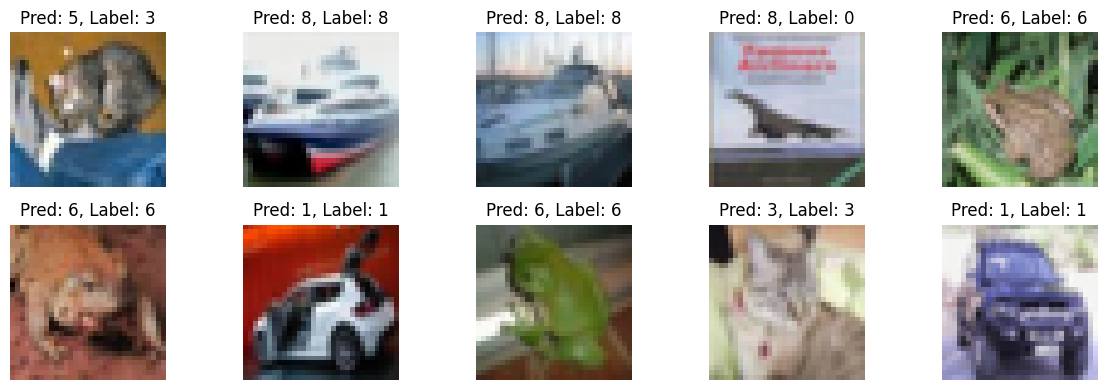

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# CIFAR10 normalization values
mean = np.array([0.4914, 0.4822, 0.4465])
std  = np.array([0.2023, 0.1994, 0.2010])

model.eval()
images, labels = next(iter(test_Loader))
images, labels = images.to(device), labels.to(device)

with torch.no_grad():
    outputs = model(images)
    pred = outputs.argmax(dim=1)

# move to CPU
images = images.cpu()
pred = pred.cpu()
labels = labels.cpu()

# denormalize function
def denormalize(img):
    img = img.permute(1, 2, 0).numpy()   # (C,H,W) -> (H,W,C)
    img = img * std + mean               # unnormalize
    img = np.clip(img, 0, 1)
    return img

# plot first 10 images
plt.figure(figsize=(12,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = denormalize(images[i])
    plt.imshow(img)
    plt.title(f"Pred: {pred[i].item()}, Label: {labels[i].item()}")
    plt.axis('off')

plt.tight_layout()
plt.show()
